# word embedding训练

利用金庸小说全集训练embedding模型，将金庸全集中的人名embedding应用主成分分析法降维到二维和三维，并可视化呈现。

In [23]:
import os
import jieba
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn, optim
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 加载小说文本

In [2]:
novel_dir = "./novel"
texts = []

# 遍历目录中的txt文件
for filename in os.listdir(novel_dir):
    if filename.endswith(".txt"):
        with open(os.path.join(novel_dir, filename), 'r', encoding='utf-8') as f:
            text = f.read()
            texts.append(text)

print(f"共加载{len(texts)}部小说")

共加载15部小说


### 文本预处理

#### 分词

In [6]:
def preprocess(text):
    # 移除无意义字符
    text = text.replace('\u3000', '').replace('\n', '')
    # 使用jieba进行分词
    jieba.load_userdict('D:\whu\homework\homework2\人物武功门派\金庸小说全门派.txt')
    jieba.load_userdict('D:\whu\homework\homework2\人物武功门派\金庸小说全人物.txt')
    jieba.load_userdict('D:\whu\homework\homework2\人物武功门派\金庸小说全武功.txt')

    words = jieba.lcut(text)
    # 过滤停用词
    with open('stop_words.txt', 'r', encoding='gbk') as f:
        stopwords = set([line.strip() for line in f])
    return [w for w in words if w not in stopwords and len(w) > 1]
processed_texts = [preprocess(text) for text in texts]
all_words = [word for words in processed_texts for word in words]
print(f"共处理{len(all_words)}个词")


共处理2157364个词


#### 构建词汇表

In [9]:
def build_vocab(words, min_count=5):
    word_counts = defaultdict(int)
    for word in words:
        word_counts[word] += 1
    
    vocab = [word for word, count in word_counts.items() if count >= min_count]
    word2idx = {word: i for i, word in enumerate(vocab)}
    idx2word = {i: word for word, i in word2idx.items()}
    
    return vocab, word2idx, idx2word

vocab, word2idx, idx2word = build_vocab(all_words, min_count=5)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 43206


#### 构建训练数据

In [10]:
def generate_training_data(words, word2idx, window_size=5):
    training_data = []
    for idx in range(len(words)):
        center_word = words[idx]
        if center_word not in word2idx:
            continue
        
        # 获取上下文窗口
        start = max(0, idx - window_size)
        end = min(len(words), idx + window_size + 1)
        context_words = words[start:idx] + words[idx+1:end]
        
        for context_word in context_words:
            if context_word in word2idx:
                training_data.append((word2idx[center_word], word2idx[context_word]))
    
    return training_data

training_data = generate_training_data(all_words, word2idx, window_size=5)

#### 数据集和数据加载器

In [15]:
class Word2VecDataset(Dataset):
    def __init__(self, training_data):
        self.data = training_data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx][0]),  # 中心词
            torch.tensor(self.data[idx][1])   # 上下文词
        )

dataset = Word2VecDataset(training_data)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

### 模型训练

In [16]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, embedding_dim)
        self.out_embed = nn.Embedding(vocab_size, embedding_dim)
        self.init_emb()
    
    def init_emb(self):
        # 初始化权重
        self.in_embed.weight.data.uniform_(-0.5/100, 0.5/100)
        self.out_embed.weight.data.uniform_(-0.5/100, 0.5/100)
    
    def forward(self, center, context, neg_context):
        # 正样本得分
        center_emb = self.in_embed(center)       # [batch_size, embed_dim]
        context_emb = self.out_embed(context)    # [batch_size, embed_dim]
        pos_score = torch.sum(center_emb * context_emb, dim=1)  # [batch_size]
        pos_loss = -torch.mean(torch.log(torch.sigmoid(pos_score)))
        
        # 负样本得分
        neg_emb = self.out_embed(neg_context)    # [batch_size, neg_samples, embed_dim]
        neg_score = torch.bmm(neg_emb, center_emb.unsqueeze(2)).squeeze()  # [batch_size, neg_samples]
        neg_loss = -torch.mean(torch.log(torch.sigmoid(-neg_score)))
        
        return pos_loss + neg_loss
    
    def get_embeddings(self):
        return self.in_embed.weight.data.cpu().numpy()

# 训练函数
def train_model(dataloader, vocab_size, embedding_dim=100, num_epochs=5, neg_samples=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Word2Vec(vocab_size, embedding_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        total_loss = 0
        for center, context in dataloader:
            center = center.to(device)
            context = context.to(device)
            
            # 生成负样本
            batch_size = center.size(0)
            neg_context = torch.randint(0, vocab_size, (batch_size, neg_samples)).to(device)
            
            # 计算损失
            loss = model(center, context, neg_context)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}')
    
    return model

model = train_model(dataloader, vocab_size, embedding_dim=100, num_epochs=10)
embeddings = model.get_embeddings()

Epoch 1, Loss: 0.8904
Epoch 2, Loss: 0.7764
Epoch 3, Loss: 0.7141
Epoch 4, Loss: 0.6716
Epoch 5, Loss: 0.6433
Epoch 6, Loss: 0.6245
Epoch 7, Loss: 0.6116
Epoch 8, Loss: 0.6022
Epoch 9, Loss: 0.5954
Epoch 10, Loss: 0.5900


### 可视化

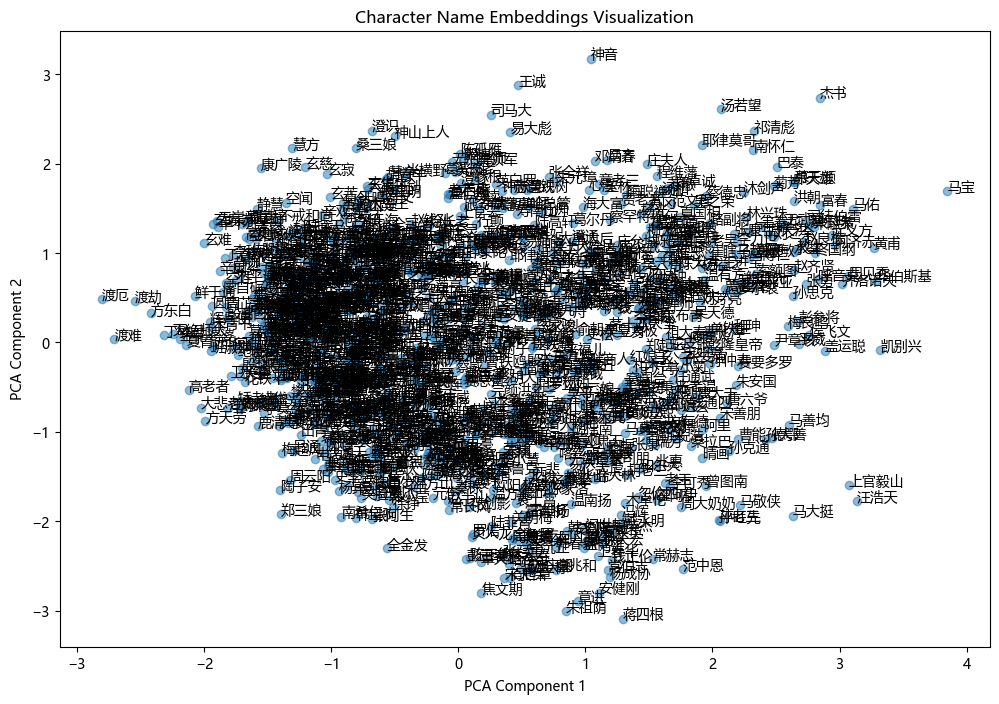

In [21]:
def visualize_names(names, embeddings, word2idx):
    name_vectors = []
    valid_names = []
    for name in names:
        if name in word2idx:
            valid_names.append(name)
            name_vectors.append(embeddings[word2idx[name]])
    
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(name_vectors)
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置默认字体为黑体
    plt.figure(figsize=(12, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.5)
    for i, name in enumerate(valid_names):
        plt.annotate(name, (vectors_2d[i, 0], vectors_2d[i, 1]))
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Character Name Embeddings Visualization')
    plt.show()
with open('D:\whu\homework\homework2\人物武功门派\金庸小说全人物.txt') as f:
    PERSON_NAMES = f.read().splitlines()
visualize_names(PERSON_NAMES, embeddings, word2idx)

#### 3D

C:\Users\95888\AppData\Local\Temp\ipykernel_20052\1160888317.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


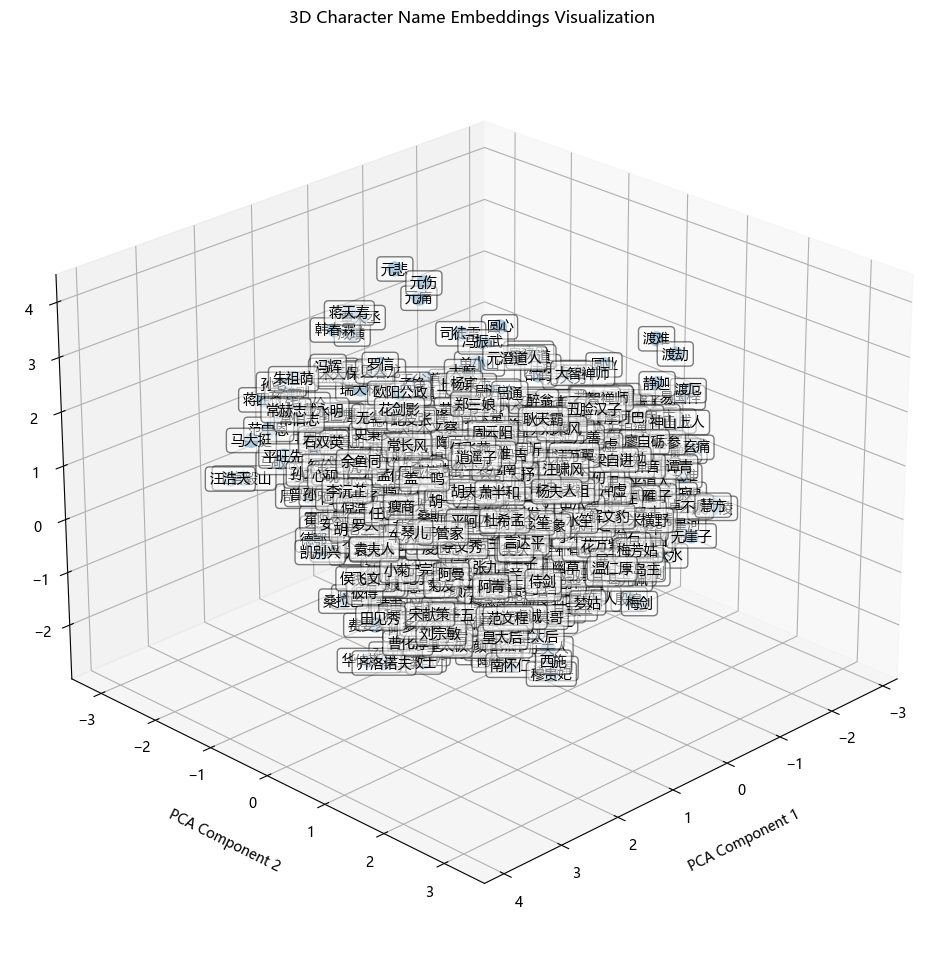

In [27]:
def visualize_3d(names, embeddings, word2idx):
    # 提取有效人名向量
    name_vectors = []
    valid_names = []
    for name in names:
        if name in word2idx:
            valid_names.append(name)
            name_vectors.append(embeddings[word2idx[name]])
    
    # 执行3D PCA降维
    pca = PCA(n_components=3)
    vectors_3d = pca.fit_transform(name_vectors)
    
    # 创建3D图形
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制散点图
    scatter = ax.scatter(
        vectors_3d[:, 0], 
        vectors_3d[:, 1],
        vectors_3d[:, 2], 
        s=100,  # 点大小
        alpha=0.7,
        cmap='viridis'
    )
    
    # 添加人名标注
    for i, name in enumerate(valid_names):
        ax.text(
            vectors_3d[i, 0], 
            vectors_3d[i, 1],
            vectors_3d[i, 2],
            name,
            fontsize=10,
            ha='center',
            va='center',
            bbox=dict(facecolor='white', alpha=0.5, boxstyle='round')
        )
    
    # 设置坐标轴标签
    ax.set_xlabel('PCA Component 1', labelpad=15)
    ax.set_ylabel('PCA Component 2', labelpad=15)
    ax.set_zlabel('PCA Component 3', labelpad=15)
    
    # 添加颜色条（如果需要颜色映射）
    # plt.colorbar(scatter, pad=0.15)
    
    # 调整视角
    ax.view_init(elev=25, azim=45)  # 仰角25度，方位角45度
    
    plt.title('3D Character Name Embeddings Visualization')
    plt.show()

visualize_3d(PERSON_NAMES, embeddings, word2idx)